# Lab 5: Spam Detection

**Deadline**: Monday, March 15, 5:00 PM

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Gautam Dawar <gautam.dawar@mail.utoronto.ca>

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:https://drive.google.com/file/d/129WihLEaxsvVBJcUCXtHN_uok_NjROl1/view?usp=sharing

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
src_path = "/content/drive/MyDrive/APS360/Lab5/SMSSpamCollection"
count = 0
for line in open(src_path):
    print(line)
    if count == 5:
        break
    count += 1


ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

ham	Ok lar... Joking wif u oni...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

ham	U dun say so early hor... U c already then say...

ham	Nah I don't think he goes to usf, he lives around here though

spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv



The label value 'spam' is for spam emails , and 'ham' for non-spam emails.

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
count_spam = 0
count_ham = 0

for line in open(src_path):
    words = line.split()
    if words[0] == 'ham':
        count_ham +=1
    elif words[0] == 'spam':
        count_spam +=1
print("There are {} spam emails and {} ham emails.".format(count_spam, count_ham))

There are 747 spam emails and 4827 ham emails.


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Advantages:
1. Char-based RNN LMs can mimic grammatically correct sequences for a wide range of languages.
2. Small vocabulary as compared to words. This means that character models will require less memory and have faster inference than their word counterparts

Disadvantages:
1. Require larger hidden layer,  computationally more expensive while word-language models train faster and generate more coherent texts.
2. The models need to learn spelling in addition to syntax, semantics. They require longer training time than word-language models, and usually have higher errors.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
import torchtext

text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset(src_path, # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

# dataset[0].sms
# dataset[0].label
# train, valid, test = ...
train, val, test = dataset.split(split_ratio = [0.6, 0.2, 0.2])

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

ANS:
Imbalanced dataset can make the model learn to predict the majority rather than learning the relationship between labels and inputs, as doing so will result in high training accuracy. For example, if a dataset comprises mostly spam emails, the model will just predict spam for all future test dataset. Balanced training set eliminates this issue, forcing the model to learn to identify spam and ham from inputs. 

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
#text_field.vocab.stoi
text_field.vocab.itos

['<unk>',
 '<pad>',
 ' ',
 'e',
 'o',
 't',
 'a',
 'n',
 'r',
 'i',
 's',
 'l',
 'u',
 '0',
 'h',
 'd',
 '.',
 'm',
 'c',
 'y',
 'w',
 'p',
 'g',
 '1',
 'f',
 '2',
 'b',
 'T',
 '8',
 'k',
 'E',
 'v',
 '5',
 'S',
 'O',
 'C',
 '4',
 'I',
 'N',
 '7',
 'A',
 'x',
 '3',
 '6',
 'R',
 '!',
 ',',
 'P',
 '9',
 'W',
 'M',
 'U',
 'H',
 'L',
 'D',
 'F',
 'G',
 'Y',
 'B',
 '/',
 "'",
 '?',
 '£',
 '-',
 '&',
 ':',
 'z',
 'X',
 'V',
 'K',
 'j',
 ')',
 ';',
 '*',
 'J',
 '+',
 '"',
 '(',
 '#',
 'q',
 'Q',
 '>',
 '@',
 '=',
 'ü',
 'Z',
 '<',
 'Ü',
 '\x92',
 '‘',
 '$',
 '|',
 '_',
 '¡',
 '“',
 '…',
 '’',
 '[',
 ']',
 '–',
 '\x93',
 '%',
 '~',
 '\t',
 '\n',
 '\\',
 '\x94',
 '\x96',
 '^',
 '\x91',
 'è',
 'ì',
 '—',
 '┾',
 '〨',
 '鈥']

ANS:
test_field.vocab.stoi is a dict that maps characters in training set to integer identifiers. 

text_field.vocab.itos are characters in training set ordered by their integer identifiers from test_field.vocab.stoi.

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

ANS:
<unk> means an unkonwn character that does not exist in the vocabulary.
<pad> means making SMS messages in a batch have the same length by padding.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
val_iter = torchtext.legacy.data.BucketIterator(val,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)    
test_iter = torchtext.legacy.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)    

In [ ]:
count = 0
for batch in train_iter:
    
    pad_count = 0
    for i in range(len(batch.sms[1])):
      pad_count += (batch.sms[1][0] - batch.sms[1][i])
    print("Batch:", count, "    Max length:", int(batch.sms[1][0],), "     Number of <pad>:", int(pad_count))
    
    if count == 10:
        break
    count += 1
    #print(len(batch))
    #print(batch.sms)
    #print(batch.label)

Batch: 0     Max length: 43      Number of <pad>: 18
Batch: 1     Max length: 61      Number of <pad>: 44
Batch: 2     Max length: 47      Number of <pad>: 27
Batch: 3     Max length: 156      Number of <pad>: 0
Batch: 4     Max length: 149      Number of <pad>: 7
Batch: 5     Max length: 116      Number of <pad>: 63
Batch: 6     Max length: 84      Number of <pad>: 41
Batch: 7     Max length: 73      Number of <pad>: 25
Batch: 8     Max length: 136      Number of <pad>: 13
Batch: 9     Max length: 160      Number of <pad>: 0
Batch: 10     Max length: 145      Number of <pad>: 28


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        self.name = "RNN"
        super(RNN, self).__init__()
        self.ident = torch.eye(input_size)
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.hidden_size = hidden_size
    def forward(self, x):
      ######################################################################################
      # need to change here
        x = self.ident[x]
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
        out = self.fc(out)
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct, total = 0, 0
    for sentence, labels in data:
        output = model(sentence[0])
        prediction = output.max(1, keepdim=True)[1]
        correct += prediction.eq(labels.view_as(prediction)).sum().item()
        total += labels.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

In [ ]:
def train_net(model, batch_size = 32, learning_rate = 1e-5, num_epochs = 5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    train_loss, val_loss, train_acc, val_acc = [], [], [], []

    epochs = range(1, num_epochs + 1)
    for epoch in range(num_epochs):
        for sentence, labels in train_iter:
            optimizer.zero_grad()
            prediction = model(sentence[0])
            loss = criterion(prediction, labels)
            loss.backward()
            optimizer.step()
        train_loss.append(float(loss))
        for sentence, labels, in val_iter:
            prediction = model(sentence[0])
            loss = criterion(prediction, labels)
        val_loss.append(float(loss))

        train_acc.append(get_accuracy(model, train_iter))
        val_acc.append(get_accuracy(model, val_iter))
        print("Epoch {}, train loss {}, val loss {}, train acc {}, val acc {}".format(epochs[epoch], train_loss[epoch], val_loss[epoch], train_acc[epoch], val_acc[epoch]))
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    plt.title("Training Curve")
    plt.plot(epochs, train_loss, label="Train")
    plt.plot(epochs, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()    



Epoch 1, train loss 0.622948408126831, val loss 0.6181749701499939, train acc 0.4813091875726865, val acc 0.8717488789237668
Epoch 2, train loss 0.7261252999305725, val loss 0.6313745379447937, train acc 0.4813091875726865, val acc 0.8717488789237668
Epoch 3, train loss 0.728157103061676, val loss 0.6492484211921692, train acc 0.4813091875726865, val acc 0.8717488789237668
Epoch 4, train loss 0.7073273062705994, val loss 0.6562331914901733, train acc 0.48114304701777705, val acc 0.8717488789237668
Epoch 5, train loss 0.6793271899223328, val loss 0.6682063341140747, train acc 0.7679016447914936, val acc 0.9139013452914798


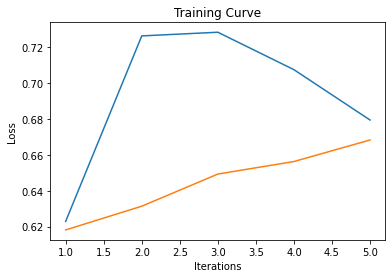

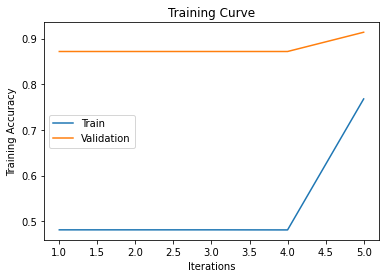

In [ ]:
# first train with default parameters, batch_size = 32, lr = 1e-5, num_epochs = 5
net1 = RNN(len(text_field.vocab.itos), len(text_field.vocab.itos), 2)
train_net(net1)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Epoch 1, train loss 0.7048433423042297, val loss 0.729080855846405, train acc 0.5230104668549593, val acc 0.13721973094170403
Epoch 2, train loss 0.48155662417411804, val loss 0.47296956181526184, train acc 0.9112809436783519, val acc 0.9596412556053812
Epoch 3, train loss 0.3207792043685913, val loss 0.2844690978527069, train acc 0.9202525336434624, val acc 0.9641255605381166
Epoch 4, train loss 0.22746263444423676, val loss 0.24251343309879303, train acc 0.9491609901977073, val acc 0.9587443946188341
Epoch 5, train loss 0.35119014978408813, val loss 0.20730997622013092, train acc 0.9534806446253531, val acc 0.9650224215246637
Epoch 6, train loss 0.04618304595351219, val loss 0.1695999652147293, train acc 0.9534806446253531, val acc 0.9614349775784753
Epoch 7, train loss 0.21975494921207428, val loss 0.06304141879081726, train acc 0.9566373151686327, val acc 0.9623318385650225
Epoch 8, train loss 0.157155379652977, val loss 0.12746089696884155, train acc 0.9582987207177271, val acc 0.

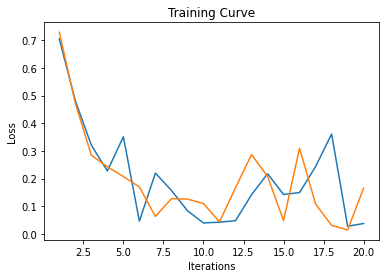

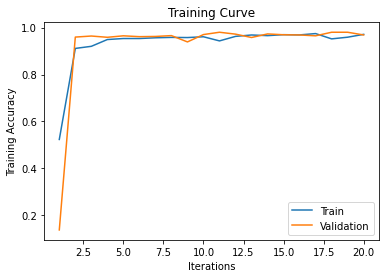

In [ ]:
# net 1 is underfitted, lr could be too small.
# always try to adjust lr first, since it is arguably the most influential parameter
# change lr to 1e-4
net2 = RNN(len(text_field.vocab.itos), len(text_field.vocab.itos), 2)
train_net(net2, batch_size = 64, learning_rate=1e-4, num_epochs=20 )

Epoch 1, train loss 0.12680810689926147, val loss 0.1912480592727661, train acc 0.9494932713075261, val acc 0.9730941704035875
Epoch 2, train loss 0.04223047196865082, val loss 0.03315307945013046, train acc 0.946502741319156, val acc 0.979372197309417
Epoch 3, train loss 0.0807725042104721, val loss 0.09434694051742554, train acc 0.9669380295730188, val acc 0.9659192825112107
Epoch 4, train loss 0.01116399746388197, val loss 0.05270537734031677, train acc 0.9707592623359362, val acc 0.968609865470852
Epoch 5, train loss 0.22145552933216095, val loss 0.03820330277085304, train acc 0.97873400897159, val acc 0.9847533632286996
Epoch 6, train loss 0.005215891636908054, val loss 0.03505570814013481, train acc 0.9843827878385114, val acc 0.9847533632286996
Epoch 7, train loss 0.18049678206443787, val loss 0.04041046276688576, train acc 0.9845489283934208, val acc 0.9757847533632287
Epoch 8, train loss 0.02122863195836544, val loss 0.02717163972556591, train acc 0.9883701611563382, val acc 0

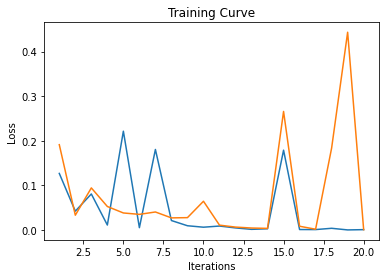

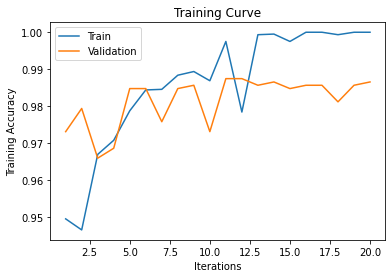

In [ ]:
# seems pretty good, net2 achieved 0.97 train acc and 0.98 val acc, now lets try to increase lr further, see what happens
# change lr to 1e-3
net3 = RNN(len(text_field.vocab.itos), len(text_field.vocab.itos), 2)
train_net(net3, batch_size = 64, learning_rate=1e-3, num_epochs=20 )

Epoch 1, train loss 0.11657227575778961, val loss 0.7479313015937805, train acc 0.8905133743146703, val acc 0.8260089686098655
Epoch 2, train loss 0.2020350992679596, val loss 0.190664142370224, train acc 0.955308190729357, val acc 0.957847533632287
Epoch 3, train loss 0.3207848072052002, val loss 0.2774386703968048, train acc 0.9609569695962784, val acc 0.9614349775784753
Epoch 4, train loss 0.3463892638683319, val loss 0.27884572744369507, train acc 0.9637813590297392, val acc 0.9641255605381166
Epoch 5, train loss 0.45674270391464233, val loss 0.04158749058842659, train acc 0.9724206678850308, val acc 0.9730941704035875
Epoch 6, train loss 0.18075788021087646, val loss 0.15789446234703064, train acc 0.9735836517693969, val acc 0.9730941704035875
Epoch 7, train loss 0.021037835627794266, val loss 0.2065114974975586, train acc 0.9790662900814089, val acc 0.9713004484304932
Epoch 8, train loss 0.046227991580963135, val loss 0.10087691992521286, train acc 0.9802292739657751, val acc 0.9

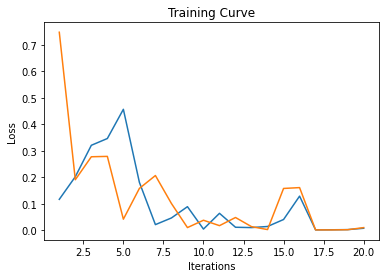

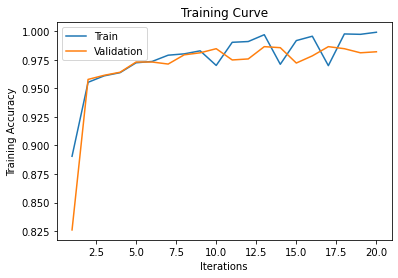

In [ ]:
# net3 consistently achieves high train and val accuracies, though its curves are not as magnificent.
# change lr to 5e-4
net4 = RNN(len(text_field.vocab.itos), len(text_field.vocab.itos), 2)
train_net(net4, batch_size = 64, learning_rate=5e-4, num_epochs=20)

Epoch 1, train loss 0.15894116461277008, val loss 0.1507040411233902, train acc 0.9380295730187739, val acc 0.968609865470852
Epoch 2, train loss 0.28828760981559753, val loss 0.1596691757440567, train acc 0.9498255524173451, val acc 0.9739910313901345
Epoch 3, train loss 0.15202203392982483, val loss 0.048990100622177124, train acc 0.9617876723708257, val acc 0.9748878923766816
Epoch 4, train loss 0.051872897893190384, val loss 0.08855587989091873, train acc 0.9740820734341252, val acc 0.9713004484304932
Epoch 5, train loss 0.021646490320563316, val loss 0.1516731232404709, train acc 0.9757434789832198, val acc 0.9865470852017937
Epoch 6, train loss 0.05000068619847298, val loss 0.28708615899086, train acc 0.9867087556072437, val acc 0.9820627802690582
Epoch 7, train loss 0.08233363181352615, val loss 0.16337154805660248, train acc 0.980561555075594, val acc 0.9865470852017937
Epoch 8, train loss 0.004488034639507532, val loss 0.03407768905162811, train acc 0.9941850805781691, val acc

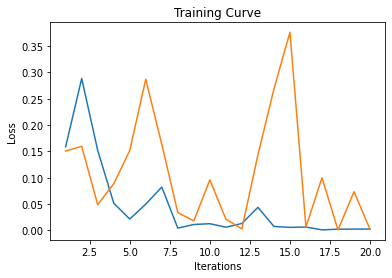

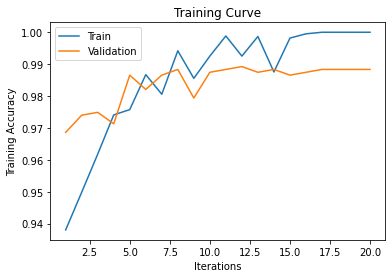

In [ ]:
# net4 is not as good as either net2 or net3
# so far net3 achieves the highest train and val acc, let's try it with different batch size, say 32
net5 = RNN(len(text_field.vocab.itos), len(text_field.vocab.itos), 2)
train_net(net5, batch_size = 32, learning_rate=1e-3, num_epochs=20)

In [ ]:
# nice, its accuracies are even higher than net3, lets go with net 5 then

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
val_spam = torchtext.legacy.data.Dataset(
    [e for e in val.examples if e.label == 1],
    val.fields)
# Create a Dataset of only non-spam validation examples
val_ham = torchtext.legacy.data.Dataset(
    [e for e in val.examples if e.label == 0],
    val.fields)

chosen_net = net5
model_path = get_model_name(net5.name, 32, 1e-3, 8)
state = torch.load(model_path)
chosen_net.load_state_dict(state)

val_spam_iter = torchtext.legacy.data.BucketIterator(val_spam,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms), 
                                           sort_within_batch=True,        
                                           repeat=False)     

val_ham_iter = torchtext.legacy.data.BucketIterator(val_ham,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms), 
                                           sort_within_batch=True,        
                                           repeat=False)   
false_positive_rate = 1 - get_accuracy(chosen_net, val_ham_iter)
false_negative_rate = 1 - get_accuracy(chosen_net, val_spam_iter)

print("false positive rate:", false_positive_rate)
print("false negative rate:", false_negative_rate)


false positive rate: 0.013374485596707841
false negative rate: 0.06293706293706292


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

ANS:
- False positive means a ham/valid message is rejected by the algorithm. This could be very impactful: for example, a message midterm may be rejected, causing one to miss the midterm exam. 

- False negative means a the user receives a spam email. This could be annoying but it is trivial in many cases. 

- We should try to minimize false positive rates.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
test_acc = get_accuracy(chosen_net, test_iter)
print("The final test accuracy is ", test_acc)

The final test accuracy is  0.9883303411131059


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in val.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam validation examples
test_ham = torchtext.legacy.data.Dataset(
    [e for e in val.examples if e.label == 0],
    test.fields)

test_spam_iter = torchtext.legacy.data.BucketIterator(test_spam,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms), 
                                           sort_within_batch=True,        
                                           repeat=False)     

test_ham_iter = torchtext.legacy.data.BucketIterator(test_ham,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms), 
                                           sort_within_batch=True,        
                                           repeat=False)   
false_positive_rate = 1 - get_accuracy(chosen_net, test_ham_iter)
false_negative_rate = 1 - get_accuracy(chosen_net, test_spam_iter)

print("false positive rate:", false_positive_rate)
print("false negative rate:", false_negative_rate)

false positive rate: 0.013374485596707841
false negative rate: 0.06293706293706292


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"

sentence_list = []
for i in range(len(msg)):
    sentence_list.append(text_field.vocab.stoi[i])

test_message = torch.LongTensor([sentence_list])
prediction = chosen_net(test_message)
prob = torch.nn.functional.softmax(prediction, dim = 1)
print("The probability of predicting spam is", float(prob[0][1]))

The probability of predicting spam is 0.025075923651456833


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

ANS:
Yes, spams are usually easy to detect, while detecting all of them accurately is difficult.
Considering false negative has much larger impact, we should not sacrifice accuracy in identifying
correct messages to find all spam emails.

We can use the Naive Bayesian classifier as our baseline model, which is exactly what we did in ECE368.
We count the number of occurences of each word in spam emails and ham emails, then we apply Laplace
smoothing to avoid situations when a word occurs in spam but not in ham and vice versa.

We assume all words are independent, and apply the MAP to classify input message as either ham or spam.
Assume prior distributoin P(spam) = pi

log(pi) + sum(log(P(word|spam))) for all words in spam email 
VS. 
log(1-pi) + sum(log(P(word|ham))) for all words in ham email

If left side is larger, we classify it as spam; if right side is larger, we classify it as ham. Here we assume parameter C to be 1.